# Markowitz Portfolio Theory
**Step 1: Carving Out the Efficient Frontier**
- Security analyst provides expected return, risk, and covariance data as an input list.
- The objective in this step is to construct a set of portfolios that form the efficient frontier, representing the optimal risk-return trade-off.

**Step 1 Substeps:**
1. Calculate the expected returns, risk (typically measured by standard deviation), and covariances between the assets in the input list.
2. For each target return, find the portfolio with the minimum risk (standard deviation) that achieves that return. These portfolios together form the efficient frontier, representing various risk-return possibilities.

**Step 2: Obtaining the Tangency Portfolio**
- In this step, the risk-free asset is introduced, and the goal is to find the portfolio that offers the best risk-return trade-off, considering both risky assets and the risk-free asset. This portfolio is known as the tangency portfolio.

**Step 2 Substeps:**
1. Introduce a risk-free asset, typically represented by a government bond with a known return and zero risk.
2. Calculate the Sharpe ratio for all portfolios on the efficient frontier. The Sharpe ratio measures the excess return of a portfolio per unit of risk.
3. Identify the portfolio on the efficient frontier with the highest Sharpe ratio. This portfolio is the tangency portfolio and is independent of the risk aversion of investors.

**Separation Property:**
- The separation property is a key concept in portfolio management, suggesting that the overall task of portfolio management can be divided into two independent tasks. These tasks are:

1. **Determination of the Optimal Risky Portfolio:** This involves choosing the portfolio of risky assets that best balances risk and return (the tangency portfolio), which is the same for all investors and independent of their risk aversion.

2. **Tailoring the Portfolio to Suit an Investor's Risk Aversion:** After the optimal risky portfolio is determined, investors can then customize their portfolios based on their individual risk preferences by allocating between the risk-free asset and the optimal risky portfolio. The proportion allocated to the risk-free asset will depend on the investor's risk aversion.

The separation property allows investors to make investment decisions based on their unique risk tolerance without affecting the selection of the optimal risky portfolio.


In [23]:
import numpy as np
import pandas as pd
import scipy.optimize as sc 
import matplotlib.pyplot as plt 
from ipywidgets import interact
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
yf.pdr_override()
import requests
from scipy.stats import norm

In [24]:
stocks=['AAPL','NFLX','FL','LMT']
end=dt.datetime.now()
start=end-dt.timedelta(days=365*5)

In [25]:
def getStockData(stocks,start,end):
    stockData=pdr.get_data_yahoo(stocks,start,end)
    return stockData

In [26]:
stockData=getStockData(stocks,start,end)

[                       0%%                      ]

c:\Users\Rama Balasubramanian\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Rama Balasubramanian\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Rama Balasubramanian\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Rama Balasubramanian\AppData\Local\Programs\Py

[*********************100%%**********************]  4 of 4 completed


In [27]:
def getDailyReturns(stockData):
    dailyReturns=stockData['Adj Close'].pct_change()
    dailyReturns=dailyReturns.dropna()
    return dailyReturns

In [28]:
dailyReturns=getDailyReturns(stockData)

In [29]:
meanReturns=(1+dailyReturns.mean())**252-1 # Annualizing the daily returns
covMatrix=dailyReturns.cov()*252 # Annualizing the covariance matrix
n=len(meanReturns)

Portfolio Variance :- 

$\sigma_P^2=w^{\prime} \sum w$

Portfolio Expected return :- 

$\quad E\left(r_P\right)=w^{\prime} \mu$

$w^{\prime} \mathbf{1}=1$ (Sum of the weights should be 1)

$\mu$ - vector of expected returns of the assets


In [30]:
def portfolioPerformance(weights,meanReturns,covMatrix):
    expectedReturn=np.sum(weights*meanReturns)
    risk=np.sqrt(np.dot(weights.T,np.dot(covMatrix, weights)))
    return expectedReturn,risk

In [31]:
def annualizedPortfolioReturn(weights,meanReturns,covMatrix):
    return portfolioPerformance(weights,meanReturns,covMatrix)[0]
def annualizedPortfolioRisk(weights,meanReturns,covMatrix):
    return portfolioPerformance(weights,meanReturns,covMatrix)[1]

## Maximum Sharpe ratio

In [32]:
# We are assuming that short selling is not allowed thus the weights cannot take negative values
# We will use the scipy package to satisfy the constraints
constraintSet=(0,1)
riskFreeRate=0.05
def negativeSharpeRatio(weights,meanReturns,covMatrix,riskFreeRate):
    expectedReturn=annualizedPortfolioReturn(weights,meanReturns,covMatrix)
    risk=annualizedPortfolioRisk(weights,meanReturns,covMatrix)
    return -(expectedReturn-riskFreeRate)/risk

def maxSharpeRatio(meanReturns,covMatrix,riskFreeRate):
    args=(meanReturns,covMatrix,riskFreeRate)
    constraints={'type':'eq','fun':lambda x:np.sum(x)-1}
    bound = constraintSet
    bounds = tuple(bound for asset in range(n))
    result=sc.minimize(negativeSharpeRatio,x0=n*[1./n],args=args,method='SLSQP',bounds=bounds,constraints=constraints)
    return result

# Minimum Variance Portfolio

$\operatorname{Min} \sigma_P^2=w^{\prime} \sum w$
constraint: $w^{\prime} \mathbf{1}=1$

where
- $w$-vector of asset weights
- $\quad \Sigma$-variance-covariance matrix

In [33]:
def minimizePortfolioVariance(meanReturns,covMatrix):
    args=(meanReturns,covMatrix)
    constraints={'type':'eq','fun':lambda x:np.sum(x)-1}
    bound = constraintSet
    bounds = tuple(bound for asset in range(n))
    result=sc.minimize(annualizedPortfolioRisk,n*[1./n],args=args,method='SLSQP',bounds=bounds,constraints=constraints)
    return result

# Efficient portfolio (E):

$
\operatorname{Min} \sigma_P^2=w^{\prime} \sum w
$

Constraints: 

- $\quad E\left(r_P\right)=w^{\prime} \mu$ 
- $w^{\prime} \mathbf{1}=1$

$\mu$ - vector of expected returns of the assets

In [34]:
def efficientPortfolios(meanReturns,covMatrix,targetReturns):
    args=(meanReturns,covMatrix)
    constraints=({'type':'eq','fun':lambda x:np.sum(x)-1},
                 {'type':'eq','fun':lambda x:annualizedPortfolioReturn(x,meanReturns,covMatrix)-targetReturns})
    bound = constraintSet
    bounds = tuple(bound for asset in range(n))
    result=sc.minimize(annualizedPortfolioRisk,n*[1./n],args=args,method='SLSQP',bounds=bounds,constraints=constraints)
    return result

In [35]:
"""The results() function summarizes the following :- 
1. Max. Sharpe Ratio portfolio(Optimal portfolio) :- Weights,Return and Risk
2. Min Variance portfolio :- Weights,Return and Risk
3. Minimum Risks for each of the random target returns """
def results(meanReturns,covMatrix):
    maxSR_portfolio=maxSharpeRatio(meanReturns,covMatrix,riskFreeRate)
    maxSR_portfolio_expectedReturn=annualizedPortfolioReturn(maxSR_portfolio['x'],meanReturns,covMatrix)
    maxSR_portfolio_risk=annualizedPortfolioRisk(maxSR_portfolio['x'],meanReturns,covMatrix)
    maxSR_allocation=pd.DataFrame(maxSR_portfolio['x'], index=meanReturns.index, columns=['allocation'])
    maxSR_allocation.allocation = [round(i,7) for i in maxSR_allocation.allocation]

    minVar_portfolio=minimizePortfolioVariance(meanReturns,covMatrix)
    minVar_portfolio_expectedReturn=annualizedPortfolioReturn(minVar_portfolio['x'],meanReturns,covMatrix)
    minVar_portfolio_risk=annualizedPortfolioRisk(minVar_portfolio['x'],meanReturns,covMatrix)
    minVar_allocation=pd.DataFrame(minVar_portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVar_allocation.allocation = [round(i,7) for i in minVar_allocation.allocation]

    efficientRisk=[]
    targetReturns=np.linspace(minVar_portfolio_expectedReturn,maxSR_portfolio_expectedReturn,30)
    for target in targetReturns:
        efficientRisk.append(efficientPortfolios(meanReturns,covMatrix,target)['fun'])
    return (maxSR_allocation,maxSR_portfolio_expectedReturn,maxSR_portfolio_risk,
            minVar_allocation,minVar_portfolio_expectedReturn,minVar_portfolio_risk,
            efficientRisk,targetReturns)

In [36]:
(maxSR_allocation,maxSR_portfolio_expectedReturn,maxSR_portfolio_risk,
            minVar_allocation,minVar_portfolio_expectedReturn,minVar_portfolio_risk,
            efficientRisk,targetReturns)=results(meanReturns,covMatrix)

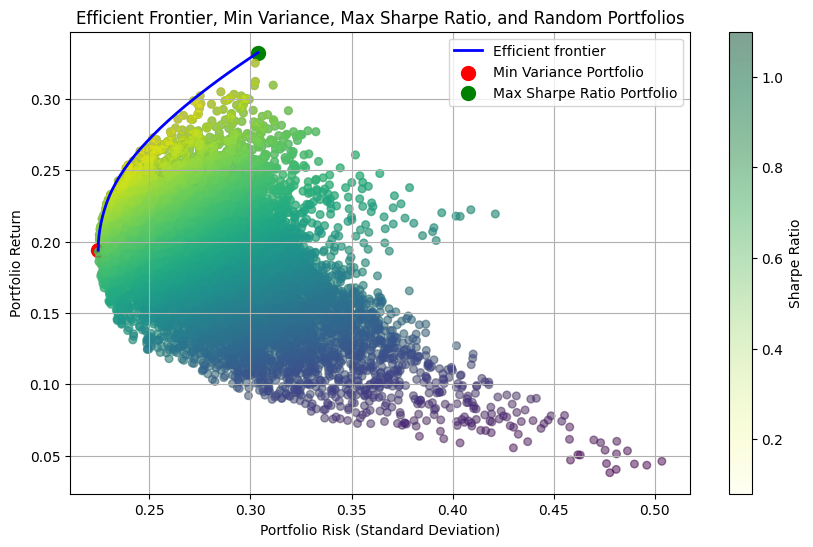

In [37]:
"""Plotting the efficient frontier"""
randomPortfolios=10000
randomPortfolios_weights=np.empty((randomPortfolios,n))
randomPortfolios_expectedReturns=np.empty(randomPortfolios)
randomPortfolios_risk=np.empty(randomPortfolios)

for i in range(randomPortfolios):
    weights=np.random.rand(len(meanReturns))
    weights=weights/weights.sum()
    randomPortfolios_weights[i]=(weights)
    randomPortfolios_expectedReturns[i]=np.sum(weights*meanReturns)
    randomPortfolios_risk[i]=np.sqrt(np.dot(weights.T,np.dot(covMatrix, weights)))


plt.figure(figsize=(10,6))
plt.plot(efficientRisk,targetReturns,label='Efficient frontier',color='blue',linewidth=2)
plt.scatter(minVar_portfolio_risk,minVar_portfolio_expectedReturn, color='red', marker='o', s=100, label='Min Variance Portfolio')
plt.scatter(maxSR_portfolio_risk,maxSR_portfolio_expectedReturn, color='green', marker='o', s=100, label='Max Sharpe Ratio Portfolio')
cmap=plt.get_cmap('YlGn')
scatter = plt.scatter(randomPortfolios_risk, randomPortfolios_expectedReturns, marker='o', s=30, alpha=0.5, c=randomPortfolios_expectedReturns/randomPortfolios_risk, cmap=cmap)
cbar=plt.colorbar(scatter,label='Sharpe Ratio',orientation='vertical')
plt.scatter(randomPortfolios_risk, randomPortfolios_expectedReturns, marker='o', s=30, alpha=0.5,c=randomPortfolios_expectedReturns/randomPortfolios_risk)
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier, Min Variance, Max Sharpe Ratio, and Random Portfolios')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()



# Capital Allocation line

$E(R_C) = y\cdot E(R_P) + (1-y)\cdot R_f$

$\sigma_C = {y \cdot \sigma_P}$


where 
- y is the allocation to the risky portfolio
- C is the complete portfolio 
- P is the risky portfolio



# Utility equation

$U = E(r_C) - 0.5 \cdot A \cdot \sigma_C^2$

where
- A is the degree of risk aversion of an investor

Assumption :- All investors are rational (no gambling)

We have found out the optimal(tangency) portfolio but depending on different degrees of risk aversion the allocation (y) can change.
We know that the objective of an investor is to maximze utility. 

$y^* = \frac{{E(r_P) - r_f}}{{A \sigma_P^2}} = \frac{{S}}{{A \sigma_P}}$

$y^*$ is the allocation maximizes utility for a given risk and return





In [38]:
"""Calculates the allocation between risk-free and risky assets for a given degree of risk aversion """
def completePortfolio(A):
    sharpeRatio=(-1) * maxSharpeRatio(meanReturns,covMatrix,riskFreeRate)['fun']
    sigma_P=maxSR_portfolio_risk
    y_optimal=(sharpeRatio)/(A*sigma_P)
    CompletePortfolioReturn=y_optimal*maxSR_portfolio_expectedReturn+(1-y_optimal)*riskFreeRate
    CompletePortfolioRisk=y_optimal*sigma_P
    x1,y1=0,riskFreeRate
    x2,y2=maxSR_portfolio_risk,maxSR_portfolio_expectedReturn

    #Plotting the efficient frontier
    plt.figure(figsize=(10,6))
    plt.plot(efficientRisk, targetReturns, label='Efficient Frontier', color='blue', linewidth=2)
    # Plotting the Minimum Variance Portfolio
    plt.scatter(minVar_portfolio_risk, minVar_portfolio_expectedReturn, color='red', marker='o', s=100, label='Min Variance Portfolio')
    # Plotting the Maximum Sharpe Ratio Portfolio
    plt.scatter(maxSR_portfolio_risk, maxSR_portfolio_expectedReturn, color='green', marker='o', s=100, label='Max Sharpe Ratio Portfolio')

    plt.plot([x1,x2],[y1,y2],color='orange',linestyle='--',label='CAL',linewidth=1)

    cmap = plt.get_cmap('YlGn')
    scatter = plt.scatter(randomPortfolios_risk, randomPortfolios_expectedReturns, marker='o', s=30, alpha=0.5, c=randomPortfolios_expectedReturns/randomPortfolios_risk, cmap=cmap)
    cbar = plt.colorbar(scatter, label='Sharpe Ratio', orientation='vertical')
    plt.scatter(randomPortfolios_risk, randomPortfolios_expectedReturns, marker='o', s=30, alpha=0.5,c=randomPortfolios_expectedReturns/randomPortfolios_risk)

    #Plotting the complete portfolio
    plt.scatter(CompletePortfolioRisk,CompletePortfolioReturn,color='purple',marker='o',s=100,label='Complete Portfolio')
    
    plt.xlabel('Risk(Standard deviation)')
    plt.ylabel('Portfolio Return')
    plt.title('Efficient Frontier, Min Variance, Max Sharpe Ratio, Random Portfolios, CAL and Complete Portfolio')
    plt.grid(True)
    plt.show()


In [39]:
"""Allows the user to visualize the CAL, and the portfolio for different levels of risk aversion"""
interact(completePortfolio,A=(1,50,1.0))

interactive(children=(FloatSlider(value=25.0, description='A', max=50.0, min=1.0, step=1.0), Output()), _dom_c…

<function __main__.completePortfolio(A)>